<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Relevant-Libraries" data-toc-modified-id="Import-Relevant-Libraries-1">Import Relevant Libraries</a></span></li><li><span><a href="#Input-Actual-Batch-Data" data-toc-modified-id="Input-Actual-Batch-Data-2">Input Actual Batch Data</a></span></li></ul></div>

# Import Relevant Libraries

In [179]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time
from datetime import date

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP, FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.hypervolume import infer_reference_point
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

from gpytorch.constraints import GreaterThan
from torch.optim import SGD
from gpytorch.mlls import ExactMarginalLogLikelihood

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

###########

from skopt.space import Space
from skopt.sampler import Lhs

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Input Actual Batch Data

In [2]:
training_data = loadtxt(f"batch_1_to_5.csv", delimiter=',')
training_data

array([[42.738, 20.028, 37.234, 78.202, 1.747, 464.793, 48.990, -6.730],
       [35.410, 63.615, 0.975, 72.708, 4.089, 128.993, 25.616, -43.130],
       [38.607, 31.172, 30.221, 66.877, 2.993, 91.991, 29.951, -17.330],
       [70.546, 21.700, 7.754, 71.495, 0.604, 147.951, 64.000, 7.760],
       [32.484, 47.606, 19.910, 62.353, 4.338, 268.694, 23.035, -32.220],
       [2.183, 47.834, 49.983, 60.888, 0.193, 227.405, 0.921, -42.530],
       [26.227, 3.214, 70.558, 73.616, 1.308, 298.860, 42.261, 12.760],
       [46.493, 8.374, 45.133, 65.425, 3.356, 41.452, 58.352, 13.640],
       [27.885, 56.712, 15.403, 69.485, 0.953, 351.240, 17.621, -38.710],
       [27.256, 28.335, 44.409, 64.019, 2.528, 381.236, 19.403, -24.740],
       [26.061, 39.625, 34.314, 78.693, 4.944, 438.393, 19.361, -30.650],
       [7.099, 50.405, 42.496, 75.713, 2.373, 198.215, 4.816, -41.710],
       [10.602, 33.869, 55.529, 69.391, 0.053, 82.476, 8.869, -32.170],
       [35.819, 10.306, 53.875, 69.788, 4.931, 126.998,

## Visualisation

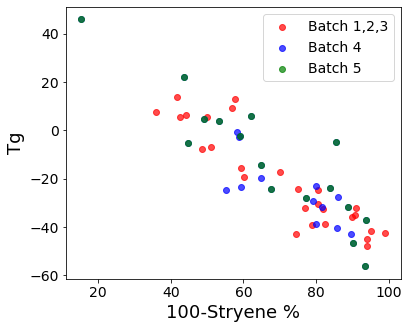

In [3]:
n_var = 6
n_obj = 2
n_constr = 1

fig, ax = plt.subplots(1, 1, figsize=(6, 5))


ax.scatter(100-training_data[:,n_var:n_var+n_obj][:27][:,0],
           training_data[:,n_var:n_var+n_obj][:27][:,1],
           label=f'Batch 1,2,3', c='r', alpha=0.7)


ax.scatter(100-training_data[:,n_var:n_var+n_obj][27:][:,0],
           training_data[:,n_var:n_var+n_obj][27:][:,1],
           label=f'Batch 4', c='b', alpha=0.7)

ax.scatter(100-training_data[:,n_var:n_var+n_obj][-16:][:,0],
           training_data[:,n_var:n_var+n_obj][-16:][:,1],
           label=f'Batch 5', c='g', alpha=0.7)


ax.set_xlabel('100-Stryene %')
ax.set_ylabel('Tg')
ax.legend()

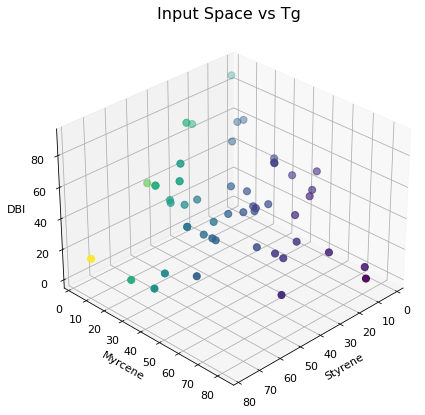

In [62]:
# set the tensor according to latest cumulative dataset
train_x = training_data[:,:n_var]
train_obj = training_data[:,n_var:n_var+n_obj]

norm = plt.Normalize(train_obj[:,1].min(), train_obj[:,1].max())

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(train_x[:,0], train_x[:,1], train_x[:,2], s=50,
             c=train_obj[:,1], norm=norm, cmap='viridis')


ax.set_title(f"Input Space vs Tg", fontsize=16)

ax.set_xlabel('Styrene', fontsize=11)
ax.set_ylabel('Myrcene', fontsize=11)
ax.set_zlabel('DBI', fontsize=11)

plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.rc('ztick', labelsize=11)

ax.view_init(azim=45)

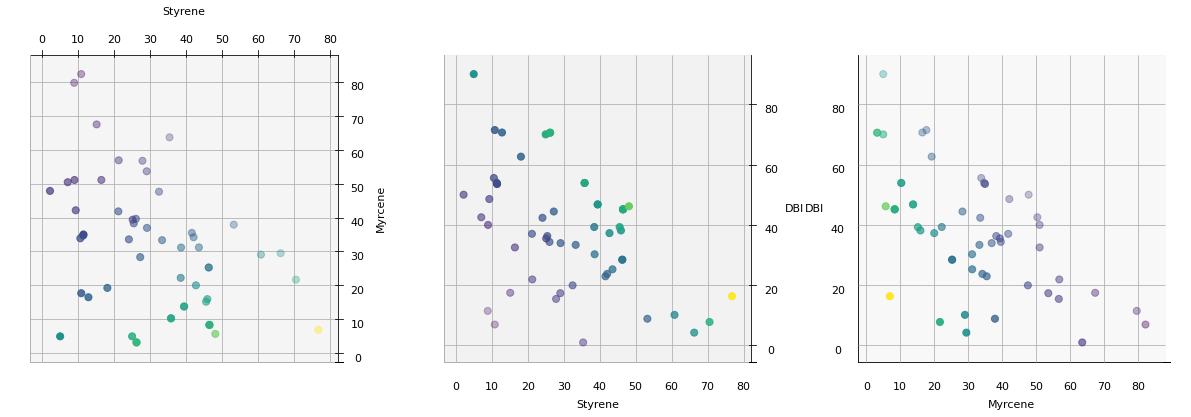

In [61]:
# (plane, (elev, azim, roll))
views = [('XY',   (90, -90, 0)),
         ('XZ',    (0, -90, 0)),
         ('YZ',    (0,   0, 0)),]
         
layout = [['XY', 'XZ', 'YZ']]  

fig, axd = plt.subplot_mosaic(layout, subplot_kw={'projection': '3d'},
                              figsize=(21, 7))
         
for plane, angles in views:
    
    if plane == 'XY':
        axd[plane].set_xlabel('Styrene', fontsize=11)
        axd[plane].set_ylabel('Myrcene', fontsize=11)

        axd[plane].set_zticklabels([])
        axd[plane].set_zlabel('')
        
    if plane == 'XZ':
        axd[plane].set_xlabel('Styrene', fontsize=11)
        axd[plane].set_zlabel('DBI', fontsize=11)
        
        axd[plane].set_yticklabels([])
        axd[plane].set_ylabel('')
        
    if plane == 'YZ':
        axd[plane].set_ylabel('Myrcene', fontsize=11)
        axd[plane].set_zlabel('DBI', fontsize=11)
        
        axd[plane].set_xticklabels([])
        axd[plane].set_xlabel('')
    
    axd[plane].set_proj_type('ortho')
    axd[plane].view_init(elev=angles[0], azim=angles[1])
    axd[plane].set_box_aspect((1,1,1), zoom=1.5)
    
    axd[plane].scatter3D(train_x[:,0], train_x[:,1], train_x[:,2], s=50,
                         c=train_obj[:,1], norm=norm, cmap='viridis')   


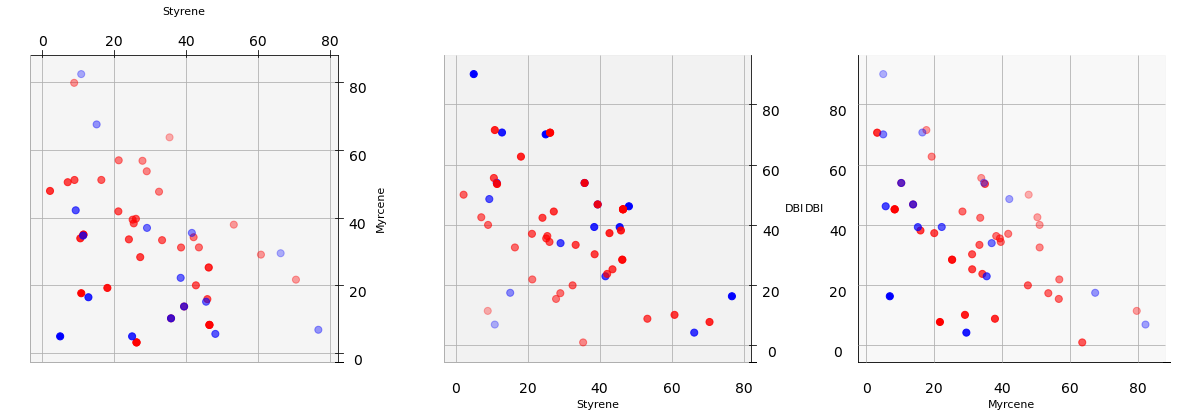

In [184]:
train_x = training_data[:,:n_var]
train_obj = training_data[:,n_var:n_var+n_obj]

# (plane, (elev, azim, roll))
views = [('XY',   (90, -90, 0)),
         ('XZ',    (0, -90, 0)),
         ('YZ',    (0,   0, 0)),]
         
layout = [['XY', 'XZ', 'YZ']]  

fig, axd = plt.subplot_mosaic(layout, subplot_kw={'projection': '3d'},
                              figsize=(21, 7))
         
for plane, angles in views:
    
    if plane == 'XY':
        axd[plane].set_xlabel('Styrene', fontsize=11)
        axd[plane].set_ylabel('Myrcene', fontsize=11)

        axd[plane].set_zticklabels([])
        axd[plane].set_zlabel('')
        
    if plane == 'XZ':
        axd[plane].set_xlabel('Styrene', fontsize=11)
        axd[plane].set_zlabel('DBI', fontsize=11)
        
        axd[plane].set_yticklabels([])
        axd[plane].set_ylabel('')
        
    if plane == 'YZ':
        axd[plane].set_ylabel('Myrcene', fontsize=11)
        axd[plane].set_zlabel('DBI', fontsize=11)
        
        axd[plane].set_xticklabels([])
        axd[plane].set_xlabel('')
    
    axd[plane].set_proj_type('ortho')
    axd[plane].view_init(elev=angles[0], azim=angles[1])
    axd[plane].set_box_aspect((1,1,1), zoom=1.5)
    
    axd[plane].scatter3D(train_x[:27+12,0], train_x[:27+12,1], train_x[:27+12,2], s=50,
                         c='r',)
    
    axd[plane].scatter3D(train_x[-16:,0], train_x[-16:,1], train_x[-16:,2], s=50,
                         c='b',)

([<matplotlib.axis.XTick at 0x2b55e88d3d0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

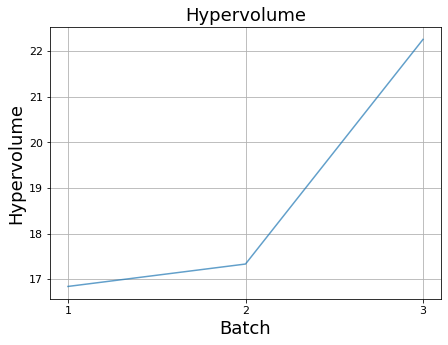

In [76]:
n_var = 6
n_obj = 2

ref_point = torch.tensor([-50, 0], **tkwargs)
hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation

train_obj = torch.tensor(training_data[:,n_var:n_var+n_obj], **tkwargs)

# we need to do some scaling for the outputs
# output 1 for styrene% should be converted to negative to force minimization
# output 2 for TG needs to be scaled to ensure maximization
train_obj[:,0] = -train_obj[:,0]
output_lower = train_obj[:,1].min()
output_upper = train_obj[:,1].max()
output_bounds = torch.vstack([output_lower, output_upper])
train_obj[:,1] = normalize(train_obj[:,1], output_bounds)

volume1 = hv.compute(train_obj[:27,])
volume2 = hv.compute(train_obj[:27+12,])
volume3 = hv.compute(train_obj[:27+12+16,])

hvs = [volume1, volume2, volume3]

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    
ax.plot(np.arange(3)+1,
        np.array(hvs),
        label=f'HV', linewidth=1.5, alpha=0.7)
    
ax.set(xlabel='Batch')
ax.grid(True)
ax.set_title(f"Hypervolume", fontsize=18)
ax.set(ylabel='Hypervolume')
#ax.legend(loc='best')

plt.xticks(np.arange(3)+1)


## Proof that fit_gpytorch_model is broken

In [84]:
####################
# initialization

n_var = 6
n_obj = 2

random_state = 42
torch.manual_seed(random_state) # gives a consistent seed based on the trial number

ref_point = torch.tensor([-50, 0], **tkwargs)
hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation

lower_bounds = torch.tensor([5.0, 5.0, 5.0, 60, 0.01, 60.0], **tkwargs) 
upper_bounds = torch.tensor([95.0, 95.0, 95.0, 80, 5.0, 480.0], **tkwargs)
problem_bounds = torch.vstack([lower_bounds, upper_bounds])

standard_bounds = torch.zeros(2, n_var, **tkwargs)
standard_bounds[1] = 1

BATCH_SIZE = 12

In [94]:
# set the tensor according to latest cumulative dataset
train_x = torch.tensor(training_data[:,:n_var], **tkwargs)
train_obj = torch.tensor(training_data[:,n_var:n_var+n_obj], **tkwargs)

# we need to do some scaling for the outputs
# output 1 for styrene% should be converted to negative to force minimization
# output 2 for TG needs to be scaled to ensure maximization
train_obj[:,0] = -train_obj[:,0]
output_lower = train_obj[:,1].min()
output_upper = train_obj[:,1].max()
output_bounds = torch.vstack([output_lower, output_upper])
train_obj[:,1] = normalize(train_obj[:,1], output_bounds)

####################
# surrogate model

train_x_gp = normalize(train_x, problem_bounds)

# form the output train_y data by concentenating train_obj with train_con 
# this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
#train_y = torch.cat([train_obj, train_con], dim=-1)
train_y = train_obj

# define and train surrogate models for objective and constraint
models = []
for i in range(train_y.shape[-1]):
    models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
model1 = ModelListGP(*models)
mll1 = SumMarginalLogLikelihood(model1.likelihood, model1)

fit_gpytorch_model(mll1)  

####################    
# acquisition function

acq_func1 = qNoisyExpectedHypervolumeImprovement(
    model=model1,
    ref_point=-ref_point, # for computing HV, must flip for BoTorch
    X_baseline=train_x_gp, # feed total list of train_x for this current iteration
    sampler=SobolQMCNormalSampler(num_samples=516),  # determines how candidates are randomly proposed before selection
    objective=IdentityMCMultiOutputObjective(outcomes=np.arange(n_obj).tolist()), # optimize first n_obj col 
    #constraints=create_idxrs(), # constraint on last n_constr col
    prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

In [95]:
# set the tensor according to latest cumulative dataset
train_x = torch.tensor(training_data[:27+12,:n_var], **tkwargs)
train_obj = torch.tensor(training_data[:27+12,n_var:n_var+n_obj], **tkwargs)

# we need to do some scaling for the outputs
# output 1 for styrene% should be converted to negative to force minimization
# output 2 for TG needs to be scaled to ensure maximization
train_obj[:,0] = -train_obj[:,0]
output_lower = train_obj[:,1].min()
output_upper = train_obj[:,1].max()
output_bounds = torch.vstack([output_lower, output_upper])
train_obj[:,1] = normalize(train_obj[:,1], output_bounds)

####################
# surrogate model

train_x_gp = normalize(train_x, problem_bounds)

# form the output train_y data by concentenating train_obj with train_con 
# this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
#train_y = torch.cat([train_obj, train_con], dim=-1)
train_y = train_obj

# define and train surrogate models for objective and constraint
models = []
for i in range(train_y.shape[-1]):
    models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
model2 = ModelListGP(*models)
mll2 = SumMarginalLogLikelihood(model2.likelihood, model2)

fit_gpytorch_model(mll2)  

####################    
# acquisition function

acq_func2 = qNoisyExpectedHypervolumeImprovement(
    model=model2,
    ref_point=-ref_point, # for computing HV, must flip for BoTorch
    X_baseline=train_x_gp, # feed total list of train_x for this current iteration
    sampler=SobolQMCNormalSampler(num_samples=516),  # determines how candidates are randomly proposed before selection
    objective=IdentityMCMultiOutputObjective(outcomes=np.arange(n_obj).tolist()), # optimize first n_obj col 
    #constraints=create_idxrs(), # constraint on last n_constr col
    prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

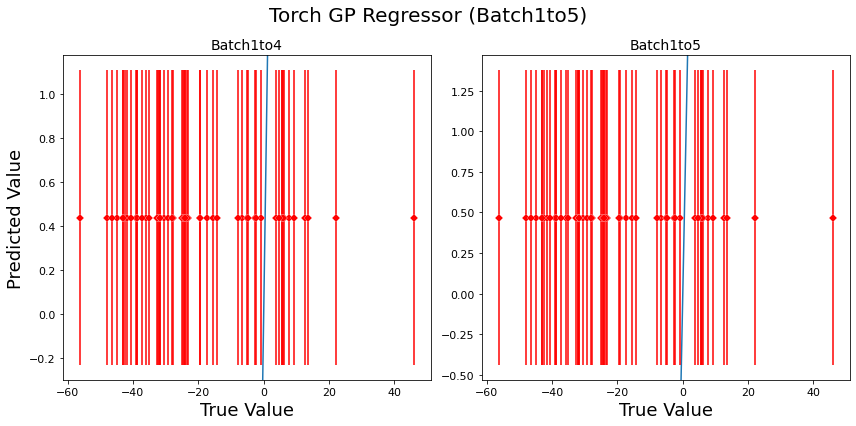

In [98]:
train_x = torch.tensor(training_data[:,:n_var], **tkwargs)
train_obj = torch.tensor(training_data[:,n_var:n_var+n_obj], **tkwargs)

fig, ax = plt.subplots(ncols = 2, figsize = (12,6))

model1.eval()
model2.eval()

for i, model, obj in zip([0,1],
                        [model1, model2],
                        ["Batch1to4", "Batch1to5"]):
    
    with torch.no_grad():
        y_true = train_obj[...,1]
        posterior = model.posterior(train_x)  
        y_pred = posterior.mean.squeeze()[...,1]
        lower, upper = posterior.mvn.confidence_region()
        yerr = upper[...,1]-lower[...,1]

        ax[i].axline((1, 1), slope=1)

        ax[i].errorbar(x=y_true.cpu().numpy(), y=y_pred.cpu().numpy(), yerr=yerr.cpu().numpy(), ls='', 
                        marker='D', mec='w', mew=0.2, mfc='r', c='r', 
                        #label='{:} R$^2$={:.3f}'.format(s,r2)
                       )

        ax[i].set_title(obj)
        ax[i].set_xlabel('True Value')
    
ax[0].set_ylabel('Predicted Value')
fig.suptitle('Torch GP Regressor (Batch1to5)')
fig.tight_layout()


# New training method

Epoch 100/500 - Loss: 1.584 noise: 1.234
Epoch 200/500 - Loss: 1.481 noise: 0.689
Epoch 300/500 - Loss: 1.439 noise: 0.454
Epoch 400/500 - Loss: 1.408 noise: 0.315
Epoch 500/500 - Loss: 1.380 noise: 0.212
Epoch 100/500 - Loss: 1.584 noise: 1.233
Epoch 200/500 - Loss: 1.479 noise: 0.685
Epoch 300/500 - Loss: 1.436 noise: 0.447
Epoch 400/500 - Loss: 1.404 noise: 0.306
Epoch 500/500 - Loss: 1.375 noise: 0.204


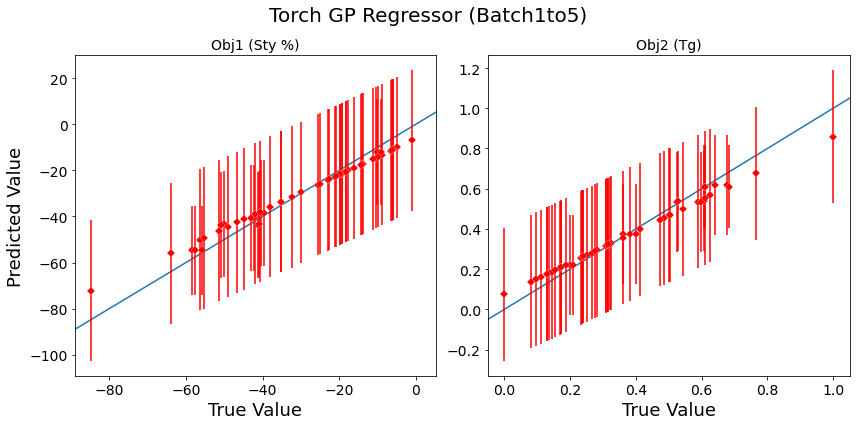

In [50]:
n_var = 6
n_obj = 2

random_state = 42
torch.manual_seed(random_state) # gives a consistent seed based on the trial number

# set the tensor according to latest cumulative dataset
train_x = torch.tensor(training_data[:,:n_var], **tkwargs)
train_obj = torch.tensor(training_data[:,n_var:n_var+n_obj], **tkwargs)

# we need to do some scaling for the outputs
# output 1 for styrene% should be converted to negative to force minimization
# output 2 for TG needs to be scaled to ensure maximization
train_obj[:,0] = -train_obj[:,0]
output_lower = train_obj[:,1].min()
output_upper = train_obj[:,1].max()
output_bounds = torch.vstack([output_lower, output_upper])
train_obj[:,1] = normalize(train_obj[:,1], output_bounds)

model1 = SingleTaskGP(train_X=train_x, train_Y=train_obj[...,0].unsqueeze(1), outcome_transform=Standardize(m=1))
model1.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

mll = ExactMarginalLogLikelihood(likelihood=model1.likelihood, model=model1)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_x)

optimizer = SGD([{'params': model1.parameters()}], lr=0.1)

NUM_EPOCHS = 500

model1.train()

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = model1(train_x)
    # Compute negative marginal log likelihood
    loss = - mll(output, model1.train_targets)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 100 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
            #f"lengthscale: {model.covar_module.base_kernel.lengthscale} " 
            f"noise: {model1.likelihood.noise.item():>4.3f}" 
         )
    optimizer.step()
    
model2 = SingleTaskGP(train_X=train_x, train_Y=train_obj[...,1].unsqueeze(1), outcome_transform=Standardize(m=1))
model2.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

mll = ExactMarginalLogLikelihood(likelihood=model2.likelihood, model=model2)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_x)

optimizer = SGD([{'params': model2.parameters()}], lr=0.1)

NUM_EPOCHS = 500

model2.train()

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = model2(train_x)
    # Compute negative marginal log likelihood
    loss = - mll(output, model2.train_targets)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 100 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
            #f"lengthscale: {model.covar_module.base_kernel.lengthscale} " 
            f"noise: {model2.likelihood.noise.item():>4.3f}" 
         )
    optimizer.step()
    

    
fig, ax = plt.subplots(ncols = 2, figsize = (12,6))

model1.eval()
model2.eval()

for i, model, obj in zip([0,1],
                        [model1, model2],
                        ["Obj1 (Sty %)", "Obj2 (Tg)"]):
    
    with torch.no_grad():
        y_true = train_obj[...,i]
        posterior = model.posterior(train_x)  
        y_pred = posterior.mean.squeeze()
        lower, upper = posterior.mvn.confidence_region()
        yerr = upper-lower

        ax[i].axline((1, 1), slope=1)

        ax[i].errorbar(x=y_true.cpu().numpy(), y=y_pred.cpu().numpy(), yerr=yerr.cpu().numpy(), ls='', 
                        marker='D', mec='w', mew=0.2, mfc='r', c='r', 
                        #label='{:} R$^2$={:.3f}'.format(s,r2)
                       )

        ax[i].set_title(obj)
        ax[i].set_xlabel('True Value')
    
ax[0].set_ylabel('Predicted Value')
fig.suptitle('Torch GP Regressor (Batch1to5)')
fig.tight_layout()

#ax[0].set_xlim(-0.0, 1.1)
#ax[0].set_ylim(-0.0, 1.1)

#ax[1].set_xlim(-0.01, 0.065)
#ax[1].set_ylim(-0.01, 0.065)

# New Optimization

In [187]:
####################
# initialization

n_var = 6
n_obj = 2

random_state = 42
torch.manual_seed(random_state) # gives a consistent seed based on the trial number

ref_point = torch.tensor([-50, 0], **tkwargs)
hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation

# set the tensor according to latest cumulative dataset
train_x = torch.tensor(training_data[:,:n_var], **tkwargs)
train_obj = torch.tensor(training_data[:,n_var:n_var+n_obj], **tkwargs)

# we need to do some scaling for the outputs
# output 1 for styrene% should be converted to negative to force minimization
# output 2 for TG needs to be scaled to ensure maximization
train_obj[:,0] = -train_obj[:,0]
output_lower = train_obj[:,1].min()
output_upper = train_obj[:,1].max()
output_bounds = torch.vstack([output_lower, output_upper])
train_obj[:,1] = normalize(train_obj[:,1], output_bounds)

lower_bounds = torch.tensor([5.0, 5.0, 5.0, 60, 0.01, 60.0], **tkwargs) 
upper_bounds = torch.tensor([95.0, 95.0, 95.0, 80, 5.0, 480.0], **tkwargs)
problem_bounds = torch.vstack([lower_bounds, upper_bounds])

standard_bounds = torch.zeros(2, n_var, **tkwargs)
standard_bounds[1] = 1

BATCH_SIZE = 12

train_x_gp = normalize(train_x, problem_bounds)

# form the output train_y data by concentenating train_obj with train_con 
# this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
train_y = train_obj

print(f"Training on {train_x_gp.shape[0]}X & {train_y.shape[0]}Y data points")

####################
# new model training

modellist = []

for i in range(train_y.shape[-1]):

    model = SingleTaskGP(train_X=train_x, train_Y=train_obj[...,i].unsqueeze(1), outcome_transform=Standardize(m=1))
    model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

    mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
    # set mll and all submodules to the specified dtype and device
    mll = mll.to(train_x)

    optimizer = SGD([{'params': model.parameters()}], lr=0.1)

    NUM_EPOCHS = 500

    model.train()

    for epoch in range(NUM_EPOCHS):
        # clear gradients
        optimizer.zero_grad()
        # forward pass through the model to obtain the output MultivariateNormal
        output = model(train_x)
        # Compute negative marginal log likelihood
        loss = - mll(output, model.train_targets)
        # back prop gradients
        loss.backward()
        
        # print every 100 iterations
        if (epoch + 1) % 100 == 0:
            print(
                f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
                #f"lengthscale: {model.covar_module.base_kernel.lengthscale} " 
                f"noise: {model.likelihood.noise.item():>4.3f}" 
             )
        
        optimizer.step()
    
    modellist.append(model)

models = ModelListGP(*modellist)

# define and train surrogate models for objective and constraint
'''
models = []
for i in range(train_y.shape[-1]):
    models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
model = ModelListGP(*models)
mll = SumMarginalLogLikelihood(model.likelihood, model)

fit_gpytorch_model(mll)  
'''
####################    
# acquisition function

acq_func = qNoisyExpectedHypervolumeImprovement(
    model=models,
    ref_point=-ref_point, # for computing HV, must flip for BoTorch
    X_baseline=train_x_gp, # feed total list of train_x for this current iteration
    sampler=SobolQMCNormalSampler(num_samples=516),
    objective=IdentityMCMultiOutputObjective(outcomes=np.arange(n_obj).tolist()), # optimize first n_obj col 
    prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

# propose candidates given defined qNEHVI acq func given model and latest observed training data
new_x, _ = optimize_acqf(
                acq_function=acq_func,
                bounds=standard_bounds, # since train_x was normalized
                q=BATCH_SIZE, # no of candidates to propose in parallel
                num_restarts=2, # no of restarts if q candidates fail to show improvement
                raw_samples=516,  # pool of samples to choose the starting points from
                options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                )

# unormalize our training inputs back to original problem bounds
new_x =  unnormalize(new_x.detach(), bounds=problem_bounds)

# perform repair on x0-3 to get 100%
for i in range(0,new_x.shape[0]):
    new_x[i,:3] = new_x[i,:3]*100/new_x[i,:3].sum()

new_x

Training on 55X & 55Y data points
Epoch 100/500 - Loss: 1.584 noise: 1.234
Epoch 200/500 - Loss: 1.481 noise: 0.689
Epoch 300/500 - Loss: 1.439 noise: 0.454
Epoch 400/500 - Loss: 1.408 noise: 0.315
Epoch 500/500 - Loss: 1.380 noise: 0.212
Epoch 100/500 - Loss: 1.584 noise: 1.233
Epoch 200/500 - Loss: 1.479 noise: 0.685
Epoch 300/500 - Loss: 1.436 noise: 0.447
Epoch 400/500 - Loss: 1.404 noise: 0.306
Epoch 500/500 - Loss: 1.375 noise: 0.204


tensor([[4.181e+01, 8.497e+00, 4.969e+01, 6.973e+01, 2.428e+00, 2.645e+02],
        [2.913e+01, 3.280e+01, 3.807e+01, 7.117e+01, 2.409e+00, 2.756e+02],
        [5.295e+01, 3.540e+01, 1.166e+01, 7.635e+01, 2.395e+00, 1.441e+02],
        [2.163e+01, 2.486e+01, 5.351e+01, 6.669e+01, 2.376e+00, 3.275e+02],
        [4.567e+01, 1.205e+01, 4.227e+01, 6.044e+01, 1.663e+00, 2.421e+02],
        [1.731e+01, 6.173e+01, 2.096e+01, 6.142e+01, 1.353e+00, 9.755e+01],
        [5.243e+01, 4.142e+01, 6.145e+00, 7.243e+01, 2.532e-01, 3.915e+02],
        [4.619e+01, 2.575e+01, 2.806e+01, 7.361e+01, 3.006e+00, 2.576e+02],
        [5.570e+01, 3.302e+01, 1.128e+01, 6.353e+01, 1.582e-01, 2.936e+02],
        [2.469e+01, 1.171e+01, 6.361e+01, 7.534e+01, 1.448e+00, 1.197e+02],
        [3.354e+01, 4.064e+01, 2.582e+01, 6.516e+01, 2.734e+00, 2.108e+02],
        [6.419e+01, 5.031e+00, 3.078e+01, 6.438e+01, 3.088e+00, 4.611e+02]],
       device='cuda:0', dtype=torch.float64)

In [6]:
# Save Batch 6 Data

cols = ['Styrene (mol %)', 'Myrcene (mol %)', 'DBI (mol %)', 'Temperature (deg C)', 'AIBN (mol %)', 'Time (min)']
new_x  = pd.DataFrame(new_x.cpu().numpy() , columns = cols) # new_x needs to be transferred back to cpu and then to numpy
new_x.to_excel('23-01-16 Batch 6 Datapoints.xlsx')